# Import

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from datetime import datetime


# Config

In [3]:
class Config:
    DATASET_PATH = '/kaggle/input/skin-cancer-mnist-ham10000'
    IMAGES_DIR_PART1 = os.path.join(DATASET_PATH, 'HAM10000_images_part_1')
    IMAGES_DIR_PART2 = os.path.join(DATASET_PATH, 'HAM10000_images_part_2')
    METADATA_PATH = os.path.join(DATASET_PATH, 'HAM10000_metadata.csv')
    
    CHECKPOINT_DIR = '/kaggle/working/checkpoints'
    RESULTS_DIR = '/kaggle/working/results'
    SPLITS_DIR = '/kaggle/working/splits'
    
    BATCH_SIZE = 32
    NUM_EPOCHS = 20
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-4
    
    MODEL_NAME = 'efficientnet_b3'
    NUM_CLASSES = 7
    IMAGE_SIZE = 224
    
    OPTIMIZER = 'adam'
    SCHEDULER = 'cosine'
    
    DEVICE = 'cuda'
    NUM_WORKERS = 2
    PIN_MEMORY = True
    SEED = 42
    PATIENCE = 10

config = Config()
torch.manual_seed(config.SEED)
np.random.seed(config.SEED)


In [4]:
metadata = pd.read_csv(config.METADATA_PATH)
print(metadata.head())

if 'diagnosis' in metadata.columns:
    DIAGNOSIS_COL = 'diagnosis'
elif 'dx' in metadata.columns:
    DIAGNOSIS_COL = 'dx'

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


# Splits

In [6]:
image_to_lesion = dict(zip(metadata['image_id'], metadata['lesion_id']))

all_image_ids = []

if os.path.exists(config.IMAGES_DIR_PART1):
    images_part1 = [f.replace('.jpg', '') for f in os.listdir(config.IMAGES_DIR_PART1) if f.endswith('.jpg')]
    all_image_ids.extend(images_part1)
    print(f"Папка 1: {len(images_part1)} изображений")

if os.path.exists(config.IMAGES_DIR_PART2):
    images_part2 = [f.replace('.jpg', '') for f in os.listdir(config.IMAGES_DIR_PART2) if f.endswith('.jpg')]
    all_image_ids.extend(images_part2)
    print(f"Папка 2: {len(images_part2)} изображений")

print(f"Всего {len(all_image_ids)} изображений")

image_id_to_lesion_id = {}
for image_id in all_image_ids:
    if image_id in image_to_lesion:
        image_id_to_lesion_id[image_id] = image_to_lesion[image_id]

unique_lesion_ids = list(set(image_id_to_lesion_id.values()))
print(f"Уникальных поражений: {len(unique_lesion_ids)}")

train_lesion_ids, temp_lesion_ids = train_test_split(unique_lesion_ids, test_size=0.3, random_state=42)
val_lesion_ids, test_lesion_ids = train_test_split(temp_lesion_ids, test_size=0.5, random_state=42)

print(f"\nРазделение lesion_id:")
print(f"  Train: {len(train_lesion_ids)}")
print(f"  Val:   {len(val_lesion_ids)}")
print(f"  Test:  {len(test_lesion_ids)}")

train_images = [img_id for img_id, les_id in image_id_to_lesion_id.items() if les_id in train_lesion_ids]
val_images = [img_id for img_id, les_id in image_id_to_lesion_id.items() if les_id in val_lesion_ids]
test_images = [img_id for img_id, les_id in image_id_to_lesion_id.items() if les_id in test_lesion_ids]

print(f"\nРазделение изображений:")
print(f"  Train: {len(train_images)}")
print(f"  Val:   {len(val_images)}")
print(f"  Test:  {len(test_images)}")

os.makedirs(config.SPLITS_DIR, exist_ok=True)

with open(os.path.join(config.SPLITS_DIR, 'train.txt'), 'w') as f:
    f.write('\n'.join(train_images))

with open(os.path.join(config.SPLITS_DIR, 'val.txt'), 'w') as f:
    f.write('\n'.join(val_images))

with open(os.path.join(config.SPLITS_DIR, 'test.txt'), 'w') as f:
    f.write('\n'.join(test_images))



Папка 1: 5000 изображений
Папка 2: 5015 изображений
Всего 10015 изображений
Уникальных поражений: 7470

Разделение lesion_id:
  Train: 5229
  Val:   1120
  Test:  1121

Разделение изображений:
  Train: 7048
  Val:   1491
  Test:  1476


# Datasets

In [8]:
class MelanomaDataset(Dataset):
    def __init__(self, images_dir_part1, images_dir_part2, metadata, file_list, diagnosis_col, transform=None):
        self.images_dir_part1 = images_dir_part1
        self.images_dir_part2 = images_dir_part2
        self.metadata = metadata
        self.diagnosis_col = diagnosis_col
        self.transform = transform
        
        with open(file_list, 'r') as f:
            self.filenames = [line.strip() for line in f.readlines()]
        
        self.diagnosis_to_label = {
            'mel': 0,     # Меланома
            'nv': 1,      # Невус
            'bcc': 2,     # Базалиома
            'akiec': 3,   # Кератоз
            'bkl': 4,     # Доброкачественный кератоз
            'df': 5,      # Дерматофиброма
            'vasc': 6     # Сосудистое поражение
        }
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        
        image_path_part1 = os.path.join(self.images_dir_part1, filename + '.jpg')
        image_path_part2 = os.path.join(self.images_dir_part2, filename + '.jpg')
        
        if os.path.exists(image_path_part1):
            image_path = image_path_part1
        elif os.path.exists(image_path_part2):
            image_path = image_path_part2
        else:
            raise FileNotFoundError(f"Не найдено: {filename}")
        
        image = Image.open(image_path).convert('RGB')
        
        meta_row = self.metadata[self.metadata['image_id'] == filename]
        if len(meta_row) > 0:
            diagnosis = meta_row.iloc[0][self.diagnosis_col]
        else:
            diagnosis = 'nv'
        
        label = self.diagnosis_to_label.get(diagnosis, 1)
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)


def get_dataloaders(config, metadata, diagnosis_col):
    
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(config.IMAGE_SIZE, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize(config.IMAGE_SIZE + 20),
        transforms.CenterCrop(config.IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = MelanomaDataset(
        images_dir_part1=config.IMAGES_DIR_PART1,
        images_dir_part2=config.IMAGES_DIR_PART2,
        metadata=metadata,
        file_list=os.path.join(config.SPLITS_DIR, 'train.txt'),
        diagnosis_col=diagnosis_col,
        transform=train_transform
    )
    
    val_dataset = MelanomaDataset(
        images_dir_part1=config.IMAGES_DIR_PART1,
        images_dir_part2=config.IMAGES_DIR_PART2,
        metadata=metadata,
        file_list=os.path.join(config.SPLITS_DIR, 'val.txt'),
        diagnosis_col=diagnosis_col,
        transform=test_transform
    )
    
    test_dataset = MelanomaDataset(
        images_dir_part1=config.IMAGES_DIR_PART1,
        images_dir_part2=config.IMAGES_DIR_PART2,
        metadata=metadata,
        file_list=os.path.join(config.SPLITS_DIR, 'test.txt'),
        diagnosis_col=diagnosis_col,
        transform=test_transform
    )

    train_labels = []
    for i in range(len(train_dataset)):
        _, y = train_dataset[i]
        train_labels.append(int(y))

    num_classes = len(set(train_labels)) 
    counts = np.bincount(train_labels, minlength=num_classes)

    class_weights = 1.0 / (counts + 1e-6)
    sample_weights = class_weights[train_labels]

    sampler = WeightedRandomSampler(
        weights=torch.tensor(sample_weights, dtype=torch.double),
        num_samples=len(sample_weights),
        replacement=True
    )
    
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=sampler, 
                             num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False,
                           num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False,
                            num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY)
    
    return train_loader, val_loader, test_loader



# Data Loading

In [9]:
train_loader, val_loader, test_loader = get_dataloaders(config, metadata, DIAGNOSIS_COL)
print(f"Train samples: {len(train_loader.dataset)}")
print(f"Val samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}\n")


Train samples: 7048
Val samples: 1491
Test samples: 1476



# Model 

In [10]:
def create_model(model_name, num_classes, pretrained=True):
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=pretrained)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    elif model_name == 'efficientnet_b3':
        model = models.efficientnet_b3(pretrained=pretrained)
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, num_classes)
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=pretrained)
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, num_classes)
    return model


class MelanomaModel(nn.Module):
    def __init__(self, backbone, num_classes=7):
        super().__init__()
        self.backbone = backbone
        self.num_classes = num_classes
    
    def forward(self, x):
        return self.backbone(x)

backbone = create_model(config.MODEL_NAME, config.NUM_CLASSES, pretrained=True)
model = MelanomaModel(backbone, config.NUM_CLASSES)
print(f"Model {config.MODEL_NAME}\n")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 221MB/s]

Model efficientnet_b3



# Training

In [11]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, config):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.device = torch.device(config.DEVICE if torch.cuda.is_available() else 'cpu')
        
        self.model = self.model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        
        if config.OPTIMIZER == 'adam':
            self.optimizer = optim.Adam(self.model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
        else:
            self.optimizer = optim.SGD(self.model.parameters(), lr=config.LEARNING_RATE, momentum=0.9, weight_decay=config.WEIGHT_DECAY)
        
        if config.SCHEDULER == 'cosine':
            self.scheduler = CosineAnnealingLR(self.optimizer, T_max=config.NUM_EPOCHS, eta_min=1e-6)
        else:
            self.scheduler = StepLR(self.optimizer, step_size=10, gamma=0.1)
        
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.train_losses, self.val_losses = [], []
        self.train_accs, self.val_accs = [], []
    
    def train_epoch(self):
        self.model.train()
        train_loss = 0.0
        all_preds, all_labels = [], []
        
        for batch_idx, (images, labels) in enumerate(self.train_loader):
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            if (batch_idx + 1) % 50 == 0:
                print(f'  Batch [{batch_idx+1}/{len(self.train_loader)}], Loss: {loss.item():.4f}')
        
        return train_loss / len(self.train_loader), accuracy_score(all_labels, all_preds)
    
    def validate(self):
        self.model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for images, labels in self.val_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_loss = val_loss / len(self.val_loader)
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, zero_division=0, average='weighted')
        recall = recall_score(all_labels, all_preds, zero_division=0, average='weighted')
        f1 = f1_score(all_labels, all_preds, zero_division=0, average='weighted')
        
        return avg_loss, accuracy, precision, recall, f1
    
    def train(self):
        print(f"learning started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        
        for epoch in range(self.config.NUM_EPOCHS):
            print(f"Epoch {epoch+1}/{self.config.NUM_EPOCHS}")
            print("-" * 60)
            
            train_loss, train_acc = self.train_epoch()
            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)
            
            val_loss, val_acc, precision, recall, f1 = self.validate()
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)
            
            self.scheduler.step()
            
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"Val Loss:   {val_loss:.4f} | Val Acc: {val_acc:.4f}")
            print(f"Precision:  {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}\n")
            
            if val_loss < self.best_val_loss:
                print(f"New_best Loss: {val_loss:.4f}")
                self.best_val_loss = val_loss
                self.patience_counter = 0
                self.save_checkpoint('best_model.pth')
            else:
                self.patience_counter += 1
                if self.patience_counter >= self.config.PATIENCE:
                    print(f"\n early stopping!")
                    break
            print()
        
        self.load_checkpoint('best_model.pth')
        self.plot_training_history()
    
    def save_checkpoint(self, filename):
        os.makedirs(self.config.CHECKPOINT_DIR, exist_ok=True)
        filepath = os.path.join(self.config.CHECKPOINT_DIR, filename)
        torch.save(self.model.state_dict(), filepath)
    
    def load_checkpoint(self, filename):
        filepath = os.path.join(self.config.CHECKPOINT_DIR, filename)
        self.model.load_state_dict(torch.load(filepath, map_location=self.device))
    
    def plot_training_history(self):
        os.makedirs(self.config.RESULTS_DIR, exist_ok=True)
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        axes[0].plot(self.train_losses, label='Train Loss')
        axes[0].plot(self.val_losses, label='Val Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Loss')
        axes[0].legend()
        axes[0].grid(True)
        
        axes[1].plot(self.train_accs, label='Train Acc')
        axes[1].plot(self.val_accs, label='Val Acc')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Accuracy')
        axes[1].legend()
        axes[1].grid(True)
        
        plt.tight_layout()
        filepath = os.path.join(self.config.RESULTS_DIR, 'training_history.png')
        plt.savefig(filepath, dpi=300)



learning started: 2026-02-23 19:28:40
Epoch 1/20
------------------------------------------------------------
  Batch [50/221], Loss: 0.8481
  Batch [100/221], Loss: 0.5194
  Batch [150/221], Loss: 0.5043
  Batch [200/221], Loss: 0.8965
Train Loss: 0.7903 | Train Acc: 0.7245
Val Loss:   0.7208 | Val Acc: 0.7626
Precision:  0.8100 | Recall: 0.7626 | F1: 0.7627

New_best Loss: 0.7208

Epoch 2/20
------------------------------------------------------------
  Batch [50/221], Loss: 0.5992
  Batch [100/221], Loss: 0.7453
  Batch [150/221], Loss: 0.5256
  Batch [200/221], Loss: 0.3288
Train Loss: 0.6283 | Train Acc: 0.7730
Val Loss:   0.5921 | Val Acc: 0.7921
Precision:  0.8094 | Recall: 0.7921 | F1: 0.7790

New_best Loss: 0.5921

Epoch 3/20
------------------------------------------------------------
  Batch [50/221], Loss: 0.4179
  Batch [100/221], Loss: 0.4429
  Batch [150/221], Loss: 0.6229
  Batch [200/221], Loss: 0.4692
Train Loss: 0.5461 | Train Acc: 0.8056
Val Loss:   0.5663 | Val Acc

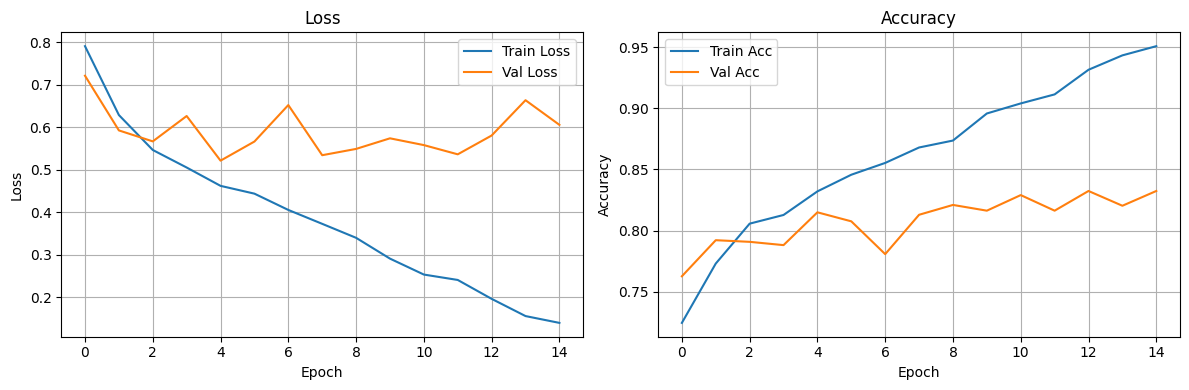

In [12]:
trainer = Trainer(model, train_loader, val_loader, config)
trainer.train()


In [13]:
from IPython.display import FileLink

%cd /kaggle/working
FileLink('checkpoints/best_model.pth')

/kaggle/working


/kaggle/working/checkpoints/best_model.pth